In [1]:
# Torch
import torch
from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear, GATv2Conv, TransformerConv
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

# Misc
import os, sys
import time
from math import ceil
import random
from IPython.display import clear_output
from termcolor import colored

# CS2
sys.path.append(os.path.abspath('../../package'))
from CS2.graph import HeteroGraphLIMESampler

# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_GRAPH_DATA = '../../data/matches-processed/cs2/hetero-graph/'

DATA_PATH_2023 = "../../data/matches-processed/cs2/tabular/2023/"
DATA_PATH_2024 = "../../data/matches-processed/cs2/tabular/2024/"

## Inferno dataset

In [4]:
file_list_2023 = [f for f in os.listdir(DATA_PATH_2023) if f.endswith("dem_df.csv")]
file_list_2024 = [f for f in os.listdir(DATA_PATH_2024) if f.endswith("dem_df.csv")][:48]
df = None

for file in file_list_2023:
    if df is None:
        df = pd.read_csv(DATA_PATH_2023 + file)
    else:
        df = pd.concat([df, pd.read_csv(DATA_PATH_2023 + file)])
    print(f"Loaded {file}")

for file in file_list_2024:
    if df is None:
        df = pd.read_csv(DATA_PATH_2024 + file)
    else:
        df = pd.concat([df, pd.read_csv(DATA_PATH_2024 + file)])
    print(f"Loaded {file}")

Loaded 100000_blast-premier-fall-final-2023-cloud9-vs-heroic-bo3-FZhx5bice3pWss26wFHIIYcloud9-vs-heroic-m2-inferno.dem_df.csv
Loaded 100001_blast-premier-fall-final-2023-cloud9-vs-natus-vincere-bo3-vxKYiMWUPLiYn9oyBq6Njdcloud9-vs-natus-vincere-m3-inferno.dem_df.csv
Loaded 100002_blast-premier-fall-final-2023-vitality-vs-cloud9-bo3-zUIRb7v6M6zsMG7pZgHbMivitality-vs-cloud9-m3-inferno.dem_df.csv
Loaded 100003_blast-premier-fall-final-2023-vitality-vs-complexity-bo3-G-ZaUjuZ52TPMUhj947hGqvitality-vs-complexity-m3-inferno.dem_df.csv
Loaded 100004_blast-premier-fall-final-2023-vitality-vs-heroic-bo3-9zNsp9vKgCG5KpvZtTZn8yvitality-vs-heroic-m2-inferno.dem_df.csv
Loaded 100005_blast-premier-world-final-2023-cloud9-vs-vitality-bo3-GcqYdsbe4wbDz8TrHeGg0Tcloud9-vs-vitality-m2-inferno.dem_df.csv
Loaded 100006_blast-premier-world-final-2023-faze-vs-g2-bo3-q1sdE-eIVJR3iWA1ZMZkolfaze-vs-g2-m1-inferno.dem_df.csv
Loaded 100007_blast-premier-world-final-2023-faze-vs-vitality-bo3-ClpxEnxu3aH1RMZr76QdPjfa

C:\Users\szmid\AppData\Local\Temp\ipykernel_41104\2118775293.py:9: DtypeWarning: Columns (1677,1678) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([df, pd.read_csv(DATA_PATH_2023 + file)])


Loaded 100010_cs-asia-championships-2023-lynn-vision-vs-mouz-bo3-3RlytQH2i-PbQZF2hly2t3lynn-vision-vs-mouz-m2-inferno.dem_df.csv


C:\Users\szmid\AppData\Local\Temp\ipykernel_41104\2118775293.py:9: DtypeWarning: Columns (1677,1678) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([df, pd.read_csv(DATA_PATH_2023 + file)])


Loaded 100011_cs-asia-championships-2023-mouz-vs-wings-up-inferno-rBbDAQbfvHTcx042LMx-mOmouz-vs-wings-up-inferno.dem_df.csv
Loaded 100012_iem-sydney-2023-gamerlegion-vs-faze-bo3-8GCYTI5P5NZCLcg9Xq9-bagamerlegion-vs-faze-m2-inferno.dem_df.csv
Loaded 100012_iem-sydney-2023-mouz-vs-vertex-inferno-wyV4hHh3mDqNZhY8zBC_ttmouz-vs-vertex-inferno.dem_df.csv
Loaded 100012_iem-sydney-2023-natus-vincere-vs-mouz-bo3-kmz24m_e2rc4e07yRHJsFcnatus-vincere-vs-mouz-m2-inferno.dem_df.csv
Loaded 100012_iem-sydney-2023-vitality-vs-faze-bo3-KYy8n7ELEDs3OUXK1CHiYpvitality-vs-faze-m2-inferno.dem_df.csv
Loaded 100012_roobet-cup-2023-fnatic-vs-ninjas-in-pyjamas-bo3-vvaeYNK3nyhj-S-LM5M0XFfnatic-vs-ninjas-in-pyjamas-m1-inferno.dem_df.csv
Loaded 100013_roobet-cup-2023-movistar-riders-vs-9z-bo3-BJXqYVFljEe0r6OFEd3Q3fmovistar-riders-vs-9z-m3-inferno.dem_df.csv
Loaded 100014_roobet-cup-2023-og-vs-fnatic-bo3-dOx3-3kXMqUOqAbeTpUgeTog-vs-fnatic-m3-inferno.dem_df.csv
Loaded 100015_thunderpick-world-championship-2023-cloud

In [5]:
pos_df = df[['CT0_X', 'CT0_Y']].rename(columns={'CT0_X': 'X', 'CT0_Y': 'Y'}).copy()

for i in range(1, 10):
    if i < 5:
        pos_df = pd.concat([pos_df, df[[f'CT{i}_X', f'CT{i}_Y']].rename(columns={f'CT{i}_X': 'X', f'CT{i}_Y': 'Y'}).copy()], axis=0)
    else:
        pos_df = pd.concat([pos_df, df[[f'T{i}_X', f'T{i}_Y']].rename(columns={f'T{i}_X': 'X', f'T{i}_Y': 'Y'}).copy()], axis=0)

pos_df['X'] = pos_df['X'].round(4).astype(int)
pos_df['Y'] = pos_df['Y'].round(4).astype(int)

pos_df['X'] = (pos_df['X'] + 1500) / (2500 + 1500)
pos_df['Y'] = (pos_df['Y'] + 500) / (3500 + 500)

pos_df = pos_df.drop_duplicates()

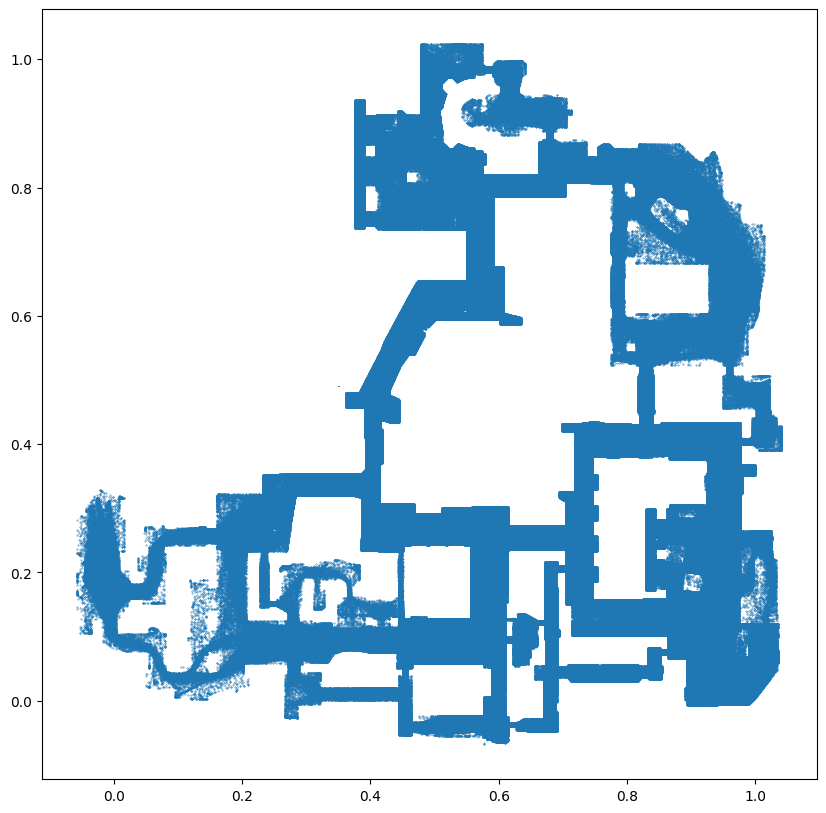

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(pos_df['X'], pos_df['Y'], s=0.1);
plt.plot([0.350, 0.351], [0.49, 0.49], color='black', linewidth=0.5)

## Graph sampling

In [22]:
hd = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)
graph = hd[1000]

In [ ]:
pldf = pd.DataFrame(graph.x_dict['player'].numpy(), columns=[col.replace('CT0_', '') for col in df.columns if col.startswith('CT0') and col != 'CT0_name'])
tpldf = pldf.copy()

# Change value proba
probability = 0.25

# ----------- Player coordinates ------------
random_filter = np.random.rand(tpldf.shape[0]) < probability
tpldf['X'] = np.where(random_filter, 
                           tpldf['X'] + np.random.normal(0, 0.006, tpldf.shape[0]), 
                           tpldf['X'])
tpldf['Y'] = np.where(random_filter, 
                           tpldf['Y'] + np.random.normal(0, 0.006, tpldf.shape[0]), 
                           tpldf['Y'])



# ----------- Player view directions ------------
random_filter = np.random.rand(tpldf.shape[0]) < probability
tpldf['pitch'] = np.where(random_filter, 
                               (tpldf['pitch'] + np.random.normal(0, 0.2, tpldf.shape[0])).clip(0, 1), 
                               tpldf['pitch'])
tpldf['yaw'] = np.where(random_filter, 
                             (tpldf['yaw'] + np.random.normal(0, 0.2, tpldf.shape[0])).clip(0, 1), 
                             tpldf['yaw'])



# ----------- Player velocities ------------
def adjust_velocity(velocity, random_filter):
    new_velocity = np.random.normal(velocity, velocity / 1.2)
    return np.where(random_filter, 
                    np.clip(new_velocity, 0, velocity),
                    velocity)

random_filter = np.random.rand(tpldf.shape[0]) < probability

tpldf['velocity_X'] = adjust_velocity(tpldf['velocity_X'], random_filter)
tpldf['velocity_Y'] = adjust_velocity(tpldf['velocity_Y'], random_filter)



# ----------- Player health ------------
tpldf['health'] = np.where(random_filter, 
                               (tpldf['health'] + np.random.normal(0, 0.07, tpldf.shape[0])).clip(0, 1).round(2),
                               tpldf['health'])

tpldf.loc[(tpldf['health'] == 0) & (tpldf['is_alive'] == 1), 'is_alive'] = 0

# ----------- Player armor ------------
tpldf['armor_value'] = np.where(random_filter, 
                               (tpldf['armor_value'] + np.random.normal(0, 0.07, tpldf.shape[0])).clip(0, 1).round(2),
                               tpldf['armor_value'])



# ----------- Player is flashed ------------
random_filter = np.random.rand(tpldf.shape[0]) < 0.05
tpldf['flash_duration'] = np.where(random_filter,
                                (tpldf['flash_duration'] + np.random.normal(0, 0.5, tpldf.shape[0])).clip(0, 1).round(4),
                                tpldf['flash_duration'])



# ----------- Player active weapon magazine ammo left % ------------
random_filter = np.random.rand(tpldf.shape[0]) < probability
ammo_filter = (tpldf['active_weapon_Knife'] == 0) & (tpldf['active_weapon_C4'] == 0) & (tpldf['active_weapon_Taser'] == 0)

tpldf['active_weapon_magazine_ammo_left_%'] = np.where(ammo_filter & random_filter, 
                                  (tpldf['active_weapon_magazine_ammo_left_%'] + np.random.normal(0, 0.1, tpldf.shape[0])).clip(0, 1), 
                                  tpldf['active_weapon_magazine_ammo_left_%'])



# ----------- Player is shooting ------------
random_filter = np.random.rand(tpldf.shape[0]) < probability
tpldf['is_shooting'] = np.where(random_filter,
                                    1 - tpldf['is_shooting'],  # Flipping the value
                                    tpldf['is_shooting'])

ammo_filter_shooting = (tpldf['is_shooting'] == 1) & (tpldf['active_weapon_magazine_ammo_left_%'] == 1)
tpldf['active_weapon_magazine_ammo_left_%'] = np.where(ammo_filter_shooting,
                                                           np.clip(tpldf['active_weapon_magazine_ammo_left_%'] - np.random.uniform(0.02, 0.12, tpldf.shape[0]), 0, 1),
                                                           tpldf['active_weapon_magazine_ammo_left_%'])



# ----------- Player is spotted ------------
random_filter = np.random.rand(tpldf.shape[0]) < 0.03
tpldf['is_spotted'] = np.where(random_filter,
                                   1 - tpldf['is_spotted'],  # Flipping the value
                                   tpldf['is_spotted'])



# ----------- Player is walking ------------
random_filter = np.random.rand(tpldf.shape[0]) < 0.15
tpldf['is_walking'] = np.where(random_filter,
                                   1 - tpldf['is_walking'],  # Flipping the value
                                   tpldf['is_walking'])



# ----------- Player is reloading ------------
reloading_filter = np.random.rand(tpldf.shape[0]) < 0.05
tpldf['is_reloading'] = np.where(reloading_filter,
                                      1 - tpldf['is_reloading'],  # Flipping the value
                                      tpldf['is_reloading'])

tpldf['is_shooting'] = np.where(tpldf['is_reloading'] == 1, 0, tpldf['is_shooting'])



# ----------- Player is scoped ------------
random_filter = np.random.rand(tpldf.shape[0]) < probability
weapon_columns = ['active_weapon_AWP', 'active_weapon_SSG 08', 'active_weapon_SG 553', 
                  'active_weapon_G3SG1', 'active_weapon_AUG', 'active_weapon_SCAR-20']

tpldf['is_scoped'] = np.where(tpldf[weapon_columns].sum(axis=1) > 0,  # Check if any of the weapons are active
                                  np.where(random_filter, 1 - tpldf['is_scoped'], tpldf['is_scoped']),
                                  0)

tpldf['zoom_lvl'] = np.where(tpldf['is_scoped'] == 1, 1, tpldf['zoom_lvl'])
tpldf['zoom_lvl'] = np.where(tpldf['is_scoped'] == 0, 0, tpldf['zoom_lvl'])


# ----------- Player is defusing ------------
tpldf['is_defusing'] = np.where(tpldf['is_defusing'] == 1,
                                    np.where(np.random.rand(tpldf.shape[0]) < 0.2, 0, 1),
                                    tpldf['is_defusing'])



# ----------- Player has C4 ------------
tpldf['inventory_C4'] = np.where(tpldf['inventory_C4'] == 1,
                                        np.where(np.random.rand(tpldf.shape[0]) < probability, 0, 1),
                                        tpldf['inventory_C4'])



# ----------- Switch active weapon ------------
inventory_columns = ['inventory_C4', 'inventory_Taser', 'inventory_USP-S', 'inventory_P2000', 'inventory_Glock-18', 'inventory_Dual Berettas', 'inventory_P250', 'inventory_Tec-9', 'inventory_CZ75 Auto', 'inventory_Five-SeveN', 'inventory_Desert Eagle', 'inventory_R8 Revolver', 'inventory_MAC-10', 'inventory_MP9', 'inventory_MP7', 'inventory_MP5-SD', 'inventory_UMP-45', 'inventory_PP-Bizon', 'inventory_P90', 'inventory_Nova', 'inventory_XM1014', 'inventory_Sawed-Off', 'inventory_MAG-7', 'inventory_M249', 'inventory_Negev', 'inventory_FAMAS', 'inventory_Galil AR', 'inventory_AK-47', 'inventory_M4A4', 'inventory_M4A1-S', 'inventory_SG 553', 'inventory_AUG', 'inventory_SSG 08', 'inventory_AWP', 'inventory_G3SG1', 'inventory_SCAR-20', 'inventory_HE Grenade', 'inventory_Flashbang', 'inventory_Smoke Grenade', 'inventory_Incendiary Grenade', 'inventory_Molotov', 'inventory_Decoy Grenade']
active_weapon_columns = ['active_weapon_C4', 'active_weapon_Knife', 'active_weapon_Taser', 'active_weapon_USP-S', 'active_weapon_P2000', 'active_weapon_Glock-18', 'active_weapon_Dual Berettas', 'active_weapon_P250', 'active_weapon_Tec-9', 'active_weapon_CZ75 Auto', 'active_weapon_Five-SeveN', 'active_weapon_Desert Eagle', 'active_weapon_R8 Revolver', 'active_weapon_MAC-10', 'active_weapon_MP9', 'active_weapon_MP7', 'active_weapon_MP5-SD', 'active_weapon_UMP-45', 'active_weapon_PP-Bizon', 'active_weapon_P90', 'active_weapon_Nova', 'active_weapon_XM1014', 'active_weapon_Sawed-Off', 'active_weapon_MAG-7', 'active_weapon_M249', 'active_weapon_Negev', 'active_weapon_FAMAS', 'active_weapon_Galil AR', 'active_weapon_AK-47', 'active_weapon_M4A4', 'active_weapon_M4A1-S', 'active_weapon_SG 553', 'active_weapon_AUG', 'active_weapon_SSG 08', 'active_weapon_AWP', 'active_weapon_G3SG1', 'active_weapon_SCAR-20', 'active_weapon_HE Grenade', 'active_weapon_Flashbang', 'active_weapon_Smoke Grenade', 'active_weapon_Incendiary Grenade', 'active_weapon_Molotov', 'active_weapon_Decoy Grenade']

def get_inventory_weapons(row):
    return [col for col in inventory_columns if row[col] == 1]

def get_active_weapon(row):
    return [col for col in active_weapon_columns if row[col] == 1]

def switch_weapon(row):

    inventory_weapons = get_inventory_weapons(row)
    active_weapon = get_active_weapon(row)

    if len(inventory_weapons) == 0:
        return row

    if len(active_weapon) == 0:
        return row
    if len(active_weapon) == 1:
        active_weapon = active_weapon[0]

    # Random roll
    if np.random.rand() < 0.5:
        return row

    else:
        new_active_weapon = random.choice(inventory_weapons)
        row[active_weapon] = 0
        row[new_active_weapon] = 1

        return row
    
tpldf = tpldf.apply(switch_weapon, axis=1)


graph['player'].x = torch.tensor(tpldf.values, dtype=torch.float32)

graph.x_dict['player']

tensor([[0.9429, 0.8571, 0.0342,  ..., 0.0769, 0.0000, 0.0000],
        [0.9699, 0.5539, 0.0450,  ..., 0.3077, 0.0000, 0.0000],
        [0.8513, 0.8294, 0.0310,  ..., 0.2308, 0.0000, 0.0000],
        ...,
        [0.5712, 0.6754, 0.0341,  ..., 0.0741, 0.0000, 0.0000],
        [0.3333, 0.3309, 0.0121,  ..., 0.0769, 0.0000, 0.0000],
        [0.6820, 0.1995, 0.0320,  ..., 0.1538, 0.2000, 0.0000]],
       dtype=torch.float64)

In [ ]:
player_closest_to_map = []

for i in range(10):
    # Get the map node with the closest coordinates to the i-th player
    player_coords = graph.x_dict['player'][i, 0:3].numpy()
    map_coords = graph.x_dict['map'][:, 1:4].numpy()
    distances = np.linalg.norm(map_coords - player_coords, axis=1)
    closest_node = np.argmin(distances)
    player_closest_to_map.append(closest_node)

del graph['player', 'closest_to', 'map']
graph['player', 'closest_to', 'map'].edge_index = torch.tensor([list(range(10)), player_closest_to_map], dtype=torch.int16)

In [312]:
mdf = pd.DataFrame(graph['map'].x, columns = ['posid', 'X', 'Y', 'Z', 'is_contact', 'is_bombsite', 'is_bomb_planted_near', 'is_burning', 'is_smoked'])

# ---------- Map molotovs ------------
random_filter = np.random.rand(mdf.shape[0]) < 0.25
burning_filter = (mdf['is_burning'] == 1)

mdf['is_burning'] = np.where(random_filter & burning_filter,
                                   1 - mdf['is_burning'],  # Flipping the value
                                   mdf['is_burning'])

# ---------- Map smokes ------------
random_filter = np.random.rand(mdf.shape[0]) < 0.25
smoked_filter = (mdf['is_smoked'] == 1)

mdf['is_smoked'] = np.where(random_filter & smoked_filter,
                                1 - mdf['is_smoked'],  # Flipping the value
                                mdf['is_smoked'])

graph['map'].x = torch.tensor(mdf.values, dtype=torch.float32)

In [337]:
list(tpldf.columns)

['X',
 'Y',
 'Z',
 'pitch',
 'yaw',
 'velocity_X',
 'velocity_Y',
 'velocity_Z',
 'health',
 'armor_value',
 'active_weapon_magazine_size',
 'active_weapon_ammo',
 'active_weapon_magazine_ammo_left_%',
 'active_weapon_max_ammo',
 'total_ammo_left',
 'active_weapon_total_ammo_left_%',
 'flash_duration',
 'flash_max_alpha',
 'balance',
 'current_equip_value',
 'round_start_equip_value',
 'cash_spent_this_round',
 'is_alive',
 'is_CT',
 'is_shooting',
 'is_crouching',
 'is_ducking',
 'is_duck_jumping',
 'is_walking',
 'is_spotted',
 'is_scoped',
 'is_defusing',
 'is_reloading',
 'is_in_bombsite',
 'zoom_lvl',
 'velo_modifier',
 'stat_kills',
 'stat_HS_kills',
 'stat_opening_kills',
 'stat_MVPs',
 'stat_deaths',
 'stat_opening_deaths',
 'stat_assists',
 'stat_flash_assists',
 'stat_damage',
 'stat_weapon_damage',
 'stat_nade_damage',
 'stat_survives',
 'stat_KPR',
 'stat_ADR',
 'stat_DPR',
 'stat_HS%',
 'stat_SPR',
 'inventory_C4',
 'inventory_Taser',
 'inventory_USP-S',
 'inventory_P2000'

In [333]:
graph.y['CT_alive_num'] = tpldf.iloc[0:5]['is_alive'].sum()
graph.y['T_alive_num'] = tpldf.iloc[5:10]['is_alive'].sum()

graph.y['CT_total_hp'] = tpldf.iloc[0:5]['health'].sum()
graph.y['T_total_hp'] = tpldf.iloc[5:10]['health'].sum()

graph.y['CT_equipment_value'] = round(sum(tpldf.iloc[0:5]['current_equip_value'] * 8450)) / 35100
graph.y['T_equipment_value'] = round(sum(tpldf.iloc[5:10]['current_equip_value'] * 8450)) / 35100

graph.y

{'numerical_match_id': 100000.0,
 'tick': 27588.0,
 'round': 0.125,
 'time': 0.65917605,
 'remaining_time': 0.54910433,
 'freeze_end': 0.0653146,
 'end': 0.07881253,
 'CT_score': 0.0,
 'T_score': 0.16666667,
 'CT_alive_num': 5.0,
 'T_alive_num': 5.0,
 'CT_total_hp': 4.59,
 'T_total_hp': 4.65,
 'CT_equipment_value': 0.05413105413105413,
 'T_equipment_value': 0.6381766381766382,
 'CT_losing_streak': 0.6,
 'T_losing_streak': 0.0,
 'is_bomb_dropped': 0.0,
 'is_bomb_being_planted': 0.0,
 'is_bomb_being_defused': 0.0,
 'is_bomb_defused': 0.0,
 'is_bomb_planted_at_A_site': 0.0,
 'is_bomb_planted_at_B_site': 0.0,
 'bomb_X': 0.0,
 'bomb_Y': 0.0,
 'bomb_Z': 0.0,
 'bomb_mx_pos1': 0.0,
 'bomb_mx_pos2': 0.0,
 'bomb_mx_pos3': 0.0,
 'bomb_mx_pos4': 0.0,
 'bomb_mx_pos5': 0.0,
 'bomb_mx_pos6': 0.0,
 'bomb_mx_pos7': 0.0,
 'bomb_mx_pos8': 0.0,
 'bomb_mx_pos9': 0.0,
 'CT_wins': 0.0}

## Graph sampling with package

In [ ]:
hetero_data = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)

In [17]:
graph = hetero_data[915]
sampler = HeteroGraphLIMESampler()
samples = sampler.sample_snapshot(graph, 100)

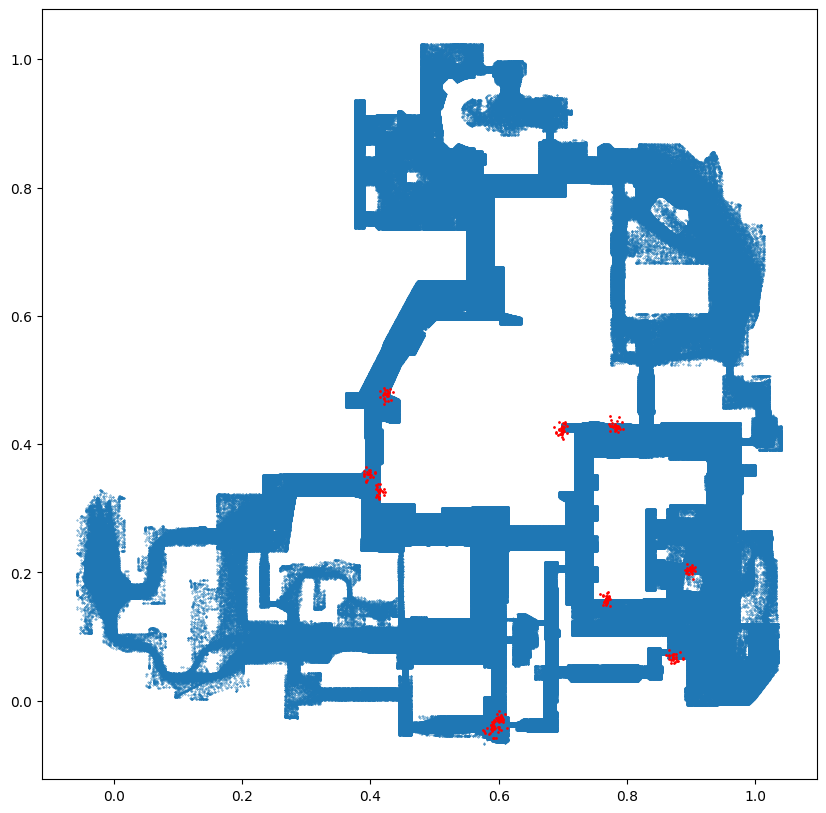

In [18]:
positions = []

for i in range(len(samples)):
    positions.extend(samples[i]['player'].x[:, 0:2].tolist())

fig = plt.figure(figsize=(10, 10))
plt.scatter(pos_df['X'], pos_df['Y'], s=0.1);
plt.scatter([x[0] for x in positions], [x[1] for x in positions], s=1, color='red');